# HIPÓTESIS 2

Los datos de los que partimos para aceptar o refutar la hipótesis sobre si se venden más vehículos por el aumento de los precios del carburante, son los que encontramos en la tarjeta de datos para dicha hipótesis. Esta tarjeta cuenta con los datos vendidos y los precios tanto de gasolina como Diesel de los años 2017 a 2022. 

La idea principal para validar esta hipótesis es estudiar por separado los coches vendidos y el precio de carburante de los países disponibles. Esto se llevará a cabo mediante algoritmos de aprendizaje no supervisado, que darán lugar a clusters o grupos. De tal forma que si el grupo de países en el que el precio de carburante es más elevado coincide con el grupo de países en el que más coches se venden, podremos aceptar la hipótesis y de lo contrario rechazarla. 

In [1]:
! pip install python-dotenv==1.0.0
! pip install sqlalchemy==2.0.23
! pip install pymysql==1.1.0
! pip install mysql-connector-python==8.2.0
! pip install cryptography==41.0.5
! pip install ydata-profiling==4.6.2
! pip install ipywidgets
! pip install scikit-learn


In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import sklearn
import matplotlib.pyplot as plt
import numpy
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
from sklearn import metrics
from scipy import cluster
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import pandas as pd

### Carga de datos

Accedemos a nuestra base de datos para cargar los datos correspondientes a la tarjeta de la hipótesis.

In [3]:
ruta_actual = os.getcwd()
directorio_superior = os.path.dirname(ruta_actual)
sys.path.append(directorio_superior)

from Acceso_BBDD.MetodosBBDD import *

In [6]:
os.chdir(directorio_superior)

dataframe  = obtener_dataframe_sql('Hipotesis_2', GOLD)
dataframe = dataframe.set_index('Country')
print(dataframe)

                CochesVendidos_2017  CochesVendidos_2018  CochesVendidos_2019  \
Country                                                                         
Austria                      379184               370315               358175   
Bulgaria                      24223                30218                31726   
Croatia                       44264                58557                61707   
Czech Republic               282540               272134               262564   
Denmark                      251763               244689               249249   
Estonia                       24834                25581                26839   
Finland                      122464               125618               117691   
France                      2439778              2519080              2570268   
Germany                     3419716              3428367              3593854   
Greece                        90447               105652               116651   
Hungary                     

### Estudio previo de los datos

Comenzamos con un breve estudio de los datos de partida, que nos ayudará posteriormente al aplicar los algoritmos 

Utilizamos la técnica de análisis de componentes principales (PCA) para reducir la dimensionalidad de nuestra tarjeta de datos. Esto nos permitirá retener las características del conjunto de datos que contribuyen más a su varianza (con mayor variabilidad). Consecuentemente, mantendremos un orden de bajo nivel, es decir conservamos la mayor cantidad posible de información. 

La visualización de los datos nos será mucho más cómoda, ya que PCA busca la proyección en la que los datos queden mejor representados en términos de mínimos cuadrados. Además, mitigamos el problema de multicolinealidad, es decir el problema de que los datos estén muy correlacionados. 

Como nuestro propósito principal en este punto es la visualización, utilizaremos dos componentes principales: 

Variance Ratio:  [0.77077263 0.15252136]


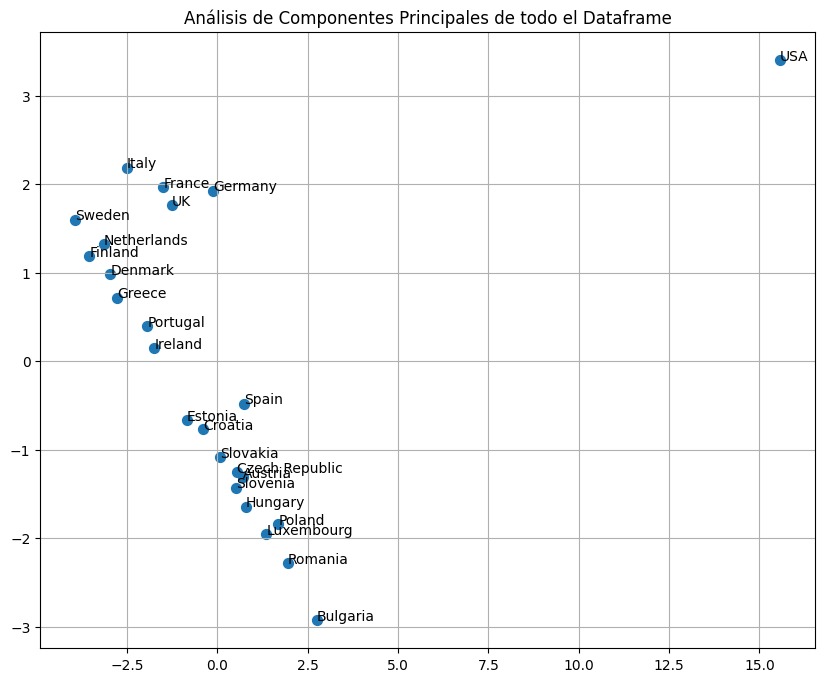

In [7]:
states = scaler.fit_transform(dataframe)
estimator = PCA (n_components = 2)
X_pca = estimator.fit_transform(states)

plt.figure(figsize=(10, 8))
plt.title("Análisis de Componentes Principales de todo el Dataframe")
plt.scatter(X_pca[:,0], X_pca[:,1], s=50)
for i in range(len(X_pca)):
    plt.text(X_pca[i, 0], X_pca[i, 1], dataframe.iloc[i, :].name)


print("Variance Ratio: ", estimator.explained_variance_ratio_) 

plt.grid()
plt.show()

Observamos que el ratio de variabilidad, especialmente por el eje Y, es bueno. Además, podemos ver como muchas de las variables son muy parecidas, exceptuando Estados Unidos o Bulgaria que son la que más se diferencia del resto. 

### Transformaciones previas

Con nuestro objetivo de estudiar por separado el número de coches vendidos y el precio de carburante, preparamos nuevos dataframes para cada uno. Transformaremos los datos de ambos a una misma escala, en nuestro caso optando por la operación MinMaxScaler, que transforma cada variable para conseguir que los elementos estén un rango determinado [0-1].  

Esto es necesario porque diferentes elementos de nuestras características pueden tener ordenes de dimensión diferentes y hay algoritmos de clustering que son sensibles a esta escalada de variables. 

Adicionalmente, volvemos a calcular la PCA de estos nuevos conjuntos de datos y la matriz de similitud de cada uno. Esto se ha llevado a cabo para obtener de nuevo una mejor representación de los datos y para saber cómo de parecidas son las variables entre sí, debido a que estos datos serán necesarios posteriormente para los algoritmos de clustering 

En la matriz de similitud de Gasolina y Diesel podemos observar que los datos tienen mayor parecido entre ellos. 

In [8]:
df_Gasolina_Diesel = dataframe[['Gasolina_2017','Gasolina_2018','Gasolina_2019','Gasolina_2020','Gasolina_2021','Gasolina_2022','Diesel_2017','Diesel_2018','Diesel_2019','Diesel_2020','Diesel_2021','Diesel_2022']]
datanorm_Gasolina_Diesel = min_max_scaler.fit_transform(df_Gasolina_Diesel)

In [9]:
df_Coches_Vendidos = dataframe[['CochesVendidos_2017','CochesVendidos_2018','CochesVendidos_2019','CochesVendidos_2020','CochesVendidos_2021','CochesVendidos_2022']]
datanorm_Coches_Vendidos = min_max_scaler.fit_transform(df_Coches_Vendidos)

matriz_similitud_Gasolina_Diesel


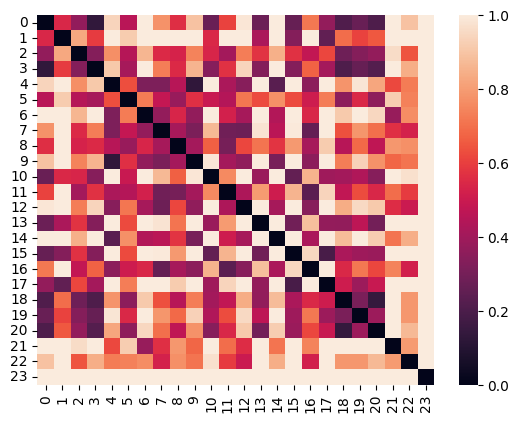

matriz_similitud_Vehiculos_Vendidos


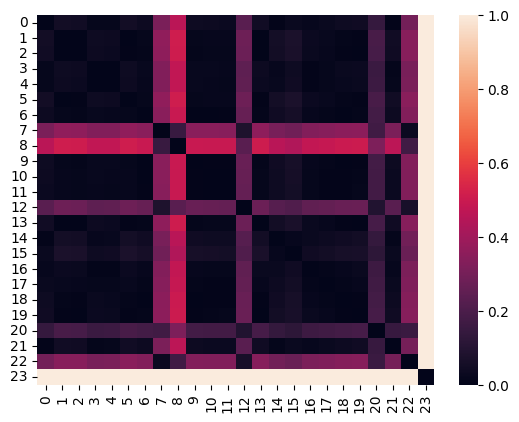

In [10]:
def calcular_matriz_similitud(datanorm, nombre_grafica):

    states_datanorm = scaler.fit_transform(datanorm)
    estimator = PCA (n_components = 2)
    pca_dataframe = estimator.fit_transform(states_datanorm)
    
    dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
    matsim = dist.pairwise(datanorm)
    ax = sns.heatmap(matsim,vmin=0, vmax=1)
    print(nombre_grafica)
    plt.show()

    return matsim, pca_dataframe


matsim_Gasolina_Diesel, Gasolina_Diesel_pca = calcular_matriz_similitud(datanorm_Gasolina_Diesel, "matriz_similitud_Gasolina_Diesel")
matsim_coches_vendidos, Coches_Vendidos_pca  = calcular_matriz_similitud(datanorm_Coches_Vendidos, "matriz_similitud_Vehiculos_Vendidos")

## Clustering  

Se ha optado por implementar diferentes algoritmos de clustering para nuestra hipótesis, con el objetivo de comparar los resultados y elegir el de mayor coherencia de agrupación según el coeficiente de Silhouette.  

A continuacón se muestra el método que nos permite representar cada uno de ellos

In [11]:
def representar_clusters(dataframe, labels, num_inicial_labels, pca_dataframe, nombre_grafica):
   
    colores = []
    for label in labels:
        if label == num_inicial_labels:
            colores.append("blue")
        elif label == 2:
            colores.append("orange")
        else:
            colores.append("green")

    plt.figure(figsize=(10, 8))
    plt.title(nombre_grafica)
    plt.scatter(pca_dataframe[:,0], pca_dataframe[:,1], c=colores,s=50)

    for i in range(len(labels)):
        plt.text(pca_dataframe[i, 0], pca_dataframe[i, 1], dataframe.iloc[i, :].name)

    plt.grid()
    plt.show()

### Clustering jerárquico

Antes de hacer clustering, mediante validación cruzada buscamos los mejores valores para "cortar" el dendograma, y el mejor método para llevarlo a cabo

En este caso, para el dataset de combustible obtenemos un coeficiente de Silhouette de 0’671 y para el número de coches 0’902. En este enfoque la cantidad óptima de clusters es 2, esto permite dividir los países estudiados en únicamente dos extremos: aquellos con mayor o menor coste de combustible (para clusters generados a partir del dataset sobre el precio de gasolina y Diesel); y aquellos punteros o no en compras de vehículos eléctricos (para clusters generados a partir del dataset de número de vehículos). Esto facilitó las futuras interpretaciones, pues desde ese momento bastaba con observar si en las agrupaciones creadas de países los que estaban en un extremo para un dataset lo estaban también en el otro.  

A continuación, se muestran las representaciones graficas de ambos apoyándonos sobre las representaciones de PCA: 

Best cut value: 2
Best linkage method: single
Best Silhouette Coefficient: 0.671


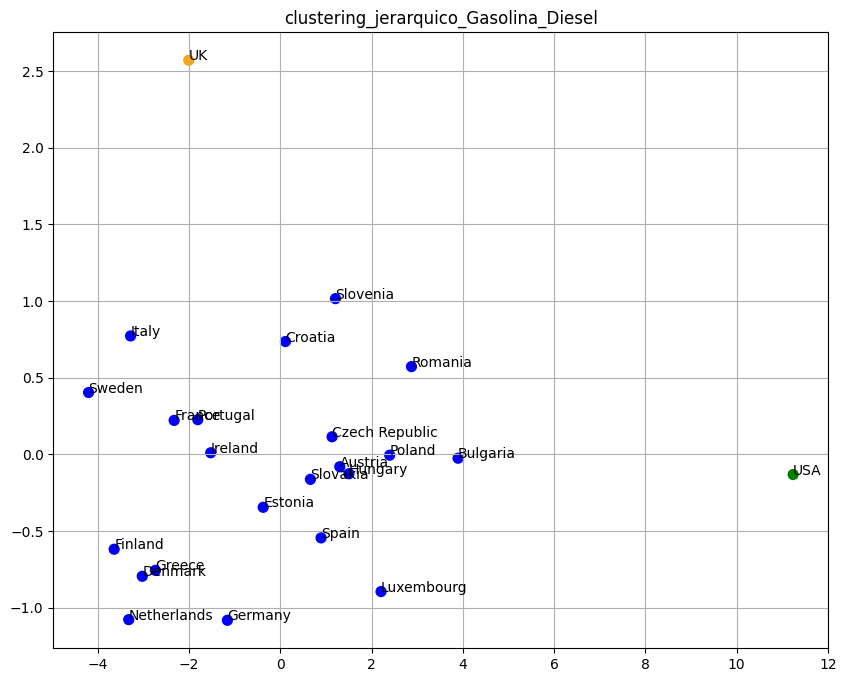

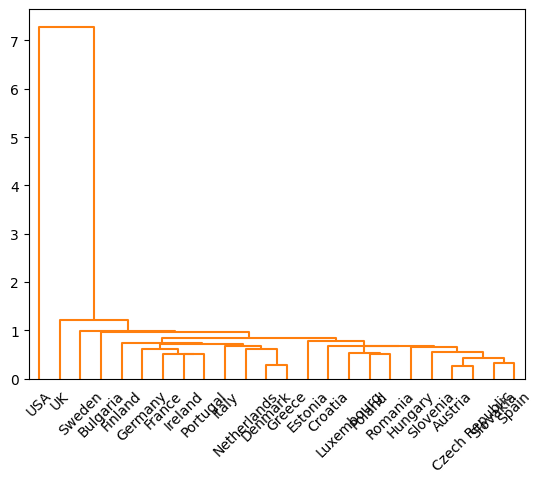

<Figure size 640x480 with 0 Axes>

Best cut value: 1
Best linkage method: single
Best Silhouette Coefficient: 0.902


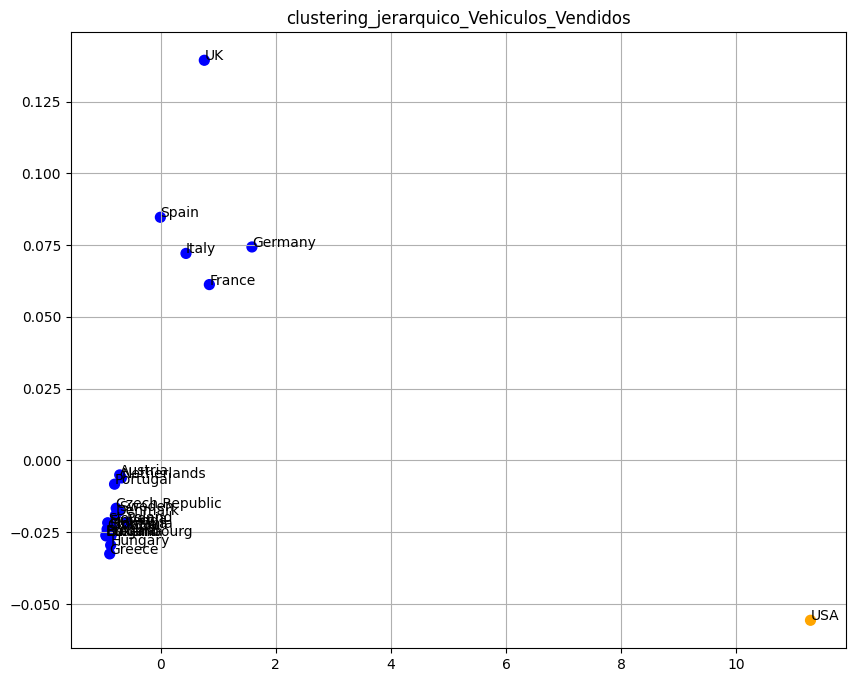

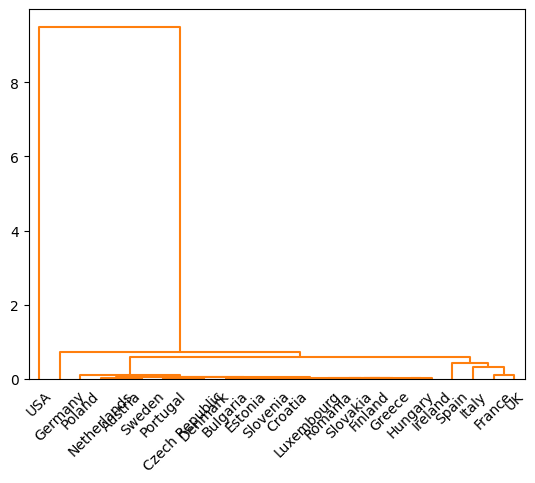

<Figure size 640x480 with 0 Axes>

In [13]:
def clustering_jerarquico(dataframe, datanorm, matsim, pca_dataframe, nombre_grafica):

    best_silhouette = -1
    best_cut = -1
    best_method = ""

    for cut_value in range(1,  6):  
        for method in ['single', 'complete', 'average', 'ward']:  
            clusters = cluster.hierarchy.linkage(matsim, method=method)
            labels = cluster.hierarchy.fcluster(clusters, cut_value, criterion='distance')
            silhouette = metrics.silhouette_score(datanorm, labels)

            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_cut = cut_value
                best_method = method

    print('Best cut value: %d' % best_cut)
    print('Best linkage method: %s' % best_method)
    print('Best Silhouette Coefficient: %0.3f' % best_silhouette) 

    clusters = cluster.hierarchy.linkage(matsim, method=best_method)
    labels = cluster.hierarchy.fcluster(clusters, 1, criterion = 'distance')
    
    representar_clusters(dataframe, labels, min(labels), pca_dataframe, nombre_grafica)

    cluster.hierarchy.dendrogram(clusters, color_threshold=18, labels = dataframe.index)

    
    f = plt.figure()
    plt.show()
    
    # Mostramos el dataset que obtenemos tras aplicar clustering
    df_aux = dataframe.copy()
    df_aux["group"] = labels

    return df_aux
    
    

df_clasificacion_Gasolina = clustering_jerarquico(df_Gasolina_Diesel, datanorm_Gasolina_Diesel, matsim_Gasolina_Diesel, Gasolina_Diesel_pca, "clustering_jerarquico_Gasolina_Diesel")
df_clasificacion_Vehiculos = clustering_jerarquico(df_Coches_Vendidos, datanorm_Coches_Vendidos, matsim_coches_vendidos, Coches_Vendidos_pca, "clustering_jerarquico_Vehiculos_Vendidos")


### Clustering K-Means  

Para este algoritmo de clustering, los resultados obtenidos de coeficiente de Silhouette no son tan buenos como los anteriores. Para el dataset de carburantes obtenemos 0’553 y para el de vehículos tan solo 0’141.  

Además, el número óptimo de clusters para ambos datasets en este caso es de tres, asimismo los grupos generados en cada caso son diferentes. Por lo tanto, esto nos complica el análisis de resultados. 

Best combination of parameters:
{'n_clusters': 3, 'init': 'k-means++'}
Best Silhouette Coefficient: 0.553


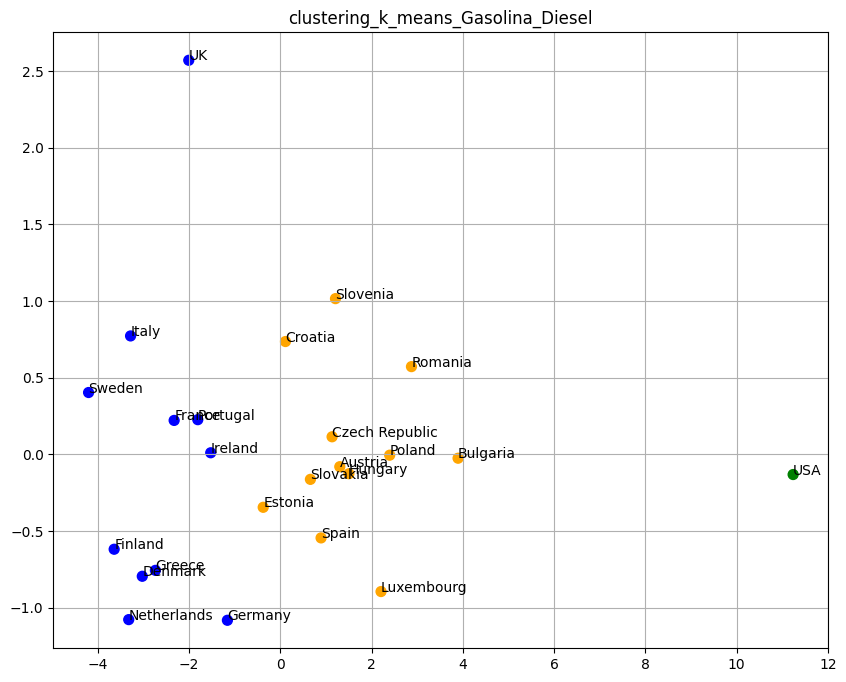

Best combination of parameters:
{'n_clusters': 3, 'init': 'k-means++'}
Best Silhouette Coefficient: 0.141


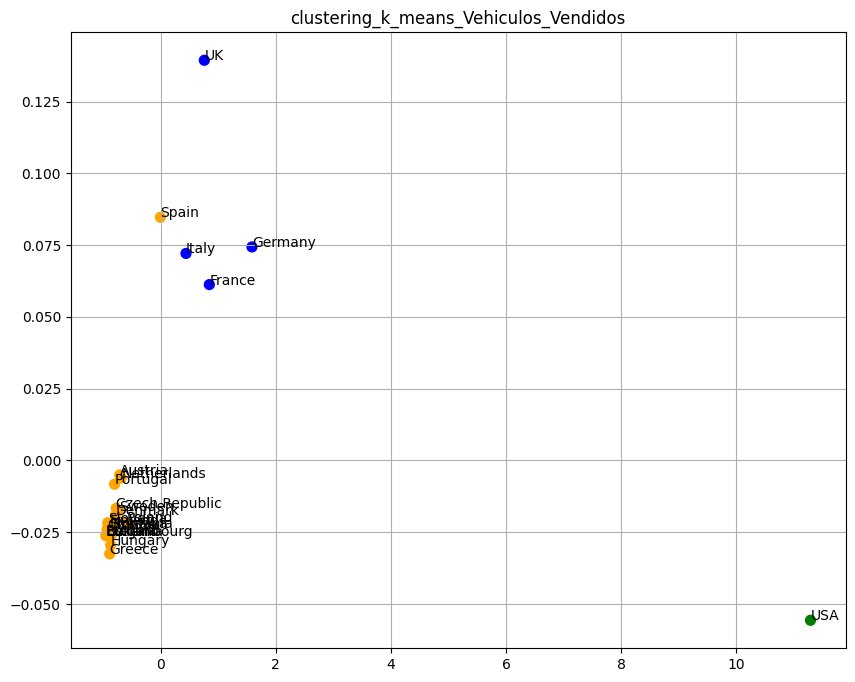

In [14]:
def clustering_k_means(dataframe, pca_dataframe, nombre_grafica):

    n_clusters_values = range(2, 7)
    init_values = ['k-means++', 'random']

    best_silhouette = -1
    best_params = {}

    for n_clusters in n_clusters_values:
        for init_method in init_values:
            km = KMeans(n_clusters=n_clusters, init=init_method, n_init=10, max_iter=300, tol=0.0001, random_state=42)
            labels = km.fit_predict(Gasolina_Diesel_pca)
            silhouette = metrics.silhouette_score(pca_dataframe, labels)

            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_params = {'n_clusters': n_clusters, 'init': init_method}

    print('Best combination of parameters:')
    print(best_params)
    print('Best Silhouette Coefficient: %0.3f' % best_silhouette)

    km = KMeans(n_clusters=best_params['n_clusters'], init=best_params['init'], n_init=10, max_iter=300, tol=0.0001, random_state=42)
    y_km = km.fit_predict(pca_dataframe)
    
    lista_invertida = []
    if nombre_grafica == "clustering_k_means_PIB":
        lista_invertida = [1 if valor == 0 else 0 for valor in km.labels_] 
        representar_clusters(dataframe, lista_invertida, min(lista_invertida), pca_dataframe, nombre_grafica)
    else:
        representar_clusters(dataframe, km.labels_, min(km.labels_), pca_dataframe, nombre_grafica)


clustering_k_means(df_Gasolina_Diesel, Gasolina_Diesel_pca, "clustering_k_means_Gasolina_Diesel")
clustering_k_means(df_Coches_Vendidos, Coches_Vendidos_pca, "clustering_k_means_Vehiculos_Vendidos")

# Clasificación 

Con el propósito de hacer un trabajo más completo y demostrar la comprensión de todos los temas vistos en la asignatura a lo largo del cuatrimestre, decidimos aprovechas las etiquetas que incluye clustering a los datos (a todos los miembros de un mismo cluster les pone la misma etiqueta, siendo esta diferente para cada grupo). Dichas etiquetas nos han permitido implementar modelos de aprendizaje supervisado, concretamente de clasificación. 

Planteamos seleccionar uno de los países de los que conocemos su número de coches vendidos cada año, pero no el precio de combustible, por ejemplo, China. Por tanto, este país estará excluido del clustering debido a que la tarjeta de datos de la que partimos para realizarlo contiene a los países de los que conocemos tanto el número de coches vendidos como los precios de carburantes. Con esta metodología evitamos cualquier tipo de data leakage. 


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn

Utilizamos la clasificación que nos proporciona el clustering Jerárquico, ya que los resultados obtenidos han resultado ser mejores. Específicamente, haciendo uso del dataframe con los datos del número de coches vendidos en cada país por año, que ahora además incluye una columna “etiqueta”, la cual es 1 si pertenece al grupo de países en los que se venden menos coches y 2 si pertenece a los que venden más coches. 

In [16]:
df_clasificacion_Vehiculos

,CochesVendidos_2017,CochesVendidos_2018,CochesVendidos_2019,CochesVendidos_2020,CochesVendidos_2021,CochesVendidos_2022,group
Country,,,,,,,
Austria,379184,370315,358175,274619,286070,226794,1
Bulgaria,24223,30218,31726,21667,23612,27717,1
Croatia,44264,58557,61707,35264,44019,41451,1
Czech Republic,282540,272134,262564,211684,214327,196360,1
Denmark,251763,244689,249249,220278,204361,163065,1
Estonia,24834,25581,26839,18697,21860,23359,1
Finland,122464,125618,117691,99389,100373,83420,1
France,2439778,2519080,2570268,1963614,1985907,1774157,1
Germany,3419716,3428367,3593854,2926093,2627208,2618944,1


Con este conjunto de datos podemos entrenar y validar un modelo sencillo de clasificación aplicando el algoritmo Gaussian Naive Bayes. Se encargará de clasificar los países de entrada en grupos de países en los que se venden pocos o muchos coches. Comprobamos que el modelo es bueno para predecir, en este caso la precisión es 1, por lo tanto, es un buen modelo. 

In [17]:
from sklearn.naive_bayes import GaussianNB

feature_selection = ['CochesVendidos_2017','CochesVendidos_2018','CochesVendidos_2019','CochesVendidos_2020','CochesVendidos_2021','CochesVendidos_2022']
X = df_clasificacion_Vehiculos[feature_selection]
y = df_clasificacion_Vehiculos['group']


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(19, 6) (5, 6)


In [19]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

In [20]:
from sklearn import metrics
# Calculate Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate Precision
precision = metrics.precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Calculate Recall
recall = metrics.recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# Calculate F1 Score
f1_score = metrics.f1_score(y_test, y_pred)
print(f"F1 Score: {f1_score}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Posteriormente a partir de los datos de coches vendidos por año en Bélgica, podemos clasificar este país en el grupo que vende menos o más coches. El modelo lo clasifica dentro de los que venden más.  

In [22]:
data_Belgica = {
    'Country': ['Belgica'],
    'CochesVendidos_2017': [578146],
    'CochesVendidos_2018': [579262],
    'CochesVendidos_2019': [584100],
    'CochesVendidos_2020': [464683],
    'CochesVendidos_2021': [416309],
    'CochesVendidos_2022': [385225]
}

df_Belgica = pd.DataFrame(data_Belgica)
df_Belgica.set_index('Country', inplace=True)
df_Belgica

,CochesVendidos_2017,CochesVendidos_2018,CochesVendidos_2019,CochesVendidos_2020,CochesVendidos_2021,CochesVendidos_2022
Country,,,,,,
Belgica,578146,579262,584100,464683,416309,385225


In [23]:
group_Belgica = gnb.predict(df_Belgica)
group_Belgica

array([1], dtype=int32)